Name Daniel M Smith
Phase4 Recommender System Project
1 on 1 Review Date

Buisness Problem:  Recommender Systems in order to see how 

We are building a Recommender system for Movies from the 100KMovieLens dataset.

#  Obtain

The Data is from the MovieLens.com site.  The data has over 100K rows in the ratings Sheet, over 9000 in the links table which links the movieid, to imdb id and to the tmdbid.  The movie table has over 9000 as well and the tage data has over 3600 rows of info.

In [1]:
import pandas as pd
ratings_df = pd.read_csv('./data/ratings.csv')
links_df = pd.read_csv('./data/links.csv')
movies_df = pd.read_csv('./data/movies.csv')
tags_df = pd.read_csv('./data/tags.csv')
ratings_df.info()
links_df.info()
movies_df.info()
tags_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null  

In [2]:
# Drop unnecessary columns
ratings_df = ratings_df.drop(columns='timestamp')
# Drop unnecessary columns
tags_df = tags_df.drop(columns='timestamp')

Dropping unneeded info.

#  Scrub

#Remove Duplicates and clean up Nans.

In [3]:
ratings_df.isna().sum()

userId     0
movieId    0
rating     0
dtype: int64

No Nans to clean up.

In [4]:
ratings_df.describe()


,userId,movieId,rating
count,100836.000000,100836.000000,100836.000000
mean,326.127564,19435.295718,3.501557
std,182.618491,35530.987199,1.042529
min,1.000000,1.000000,0.500000
25%,177.000000,1199.000000,3.000000
50%,325.000000,2991.000000,3.500000
75%,477.000000,8122.000000,4.000000
max,610.000000,193609.000000,5.000000


#  Explore

### Ratings Distribution

In [5]:
#Rating Distro

In [6]:
ratings_df['rating'].value_counts(normalize=True)

4.0    0.265957
3.0    0.198808
5.0    0.131015
3.5    0.130271
4.5    0.084801
2.0    0.074884
2.5    0.055040
1.0    0.027877
1.5    0.017762
0.5    0.013586
Name: rating, dtype: float64

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline

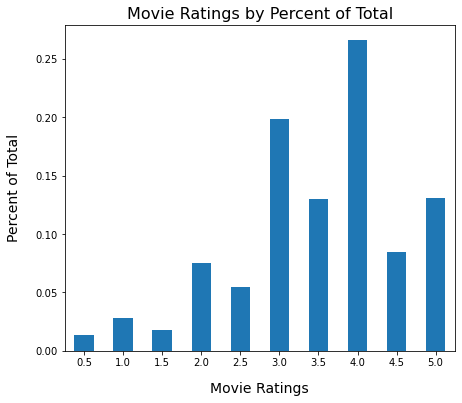

In [8]:

ratings_df['rating'].value_counts(normalize=True,sort = False).sort_index().plot(kind='bar', figsize=(7, 6), rot=0)
plt.ylabel("Percent of Total", labelpad=14, fontsize=14)
plt.xlabel("Movie Ratings", labelpad=14,fontsize=14)
plt.title("Movie Ratings by Percent of Total", fontsize=16);

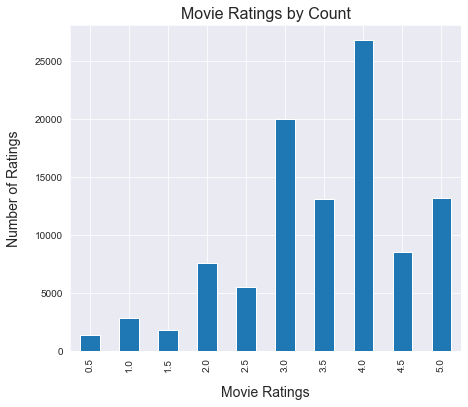

In [9]:
sns.set_style("darkgrid")
ratings_df['rating'].value_counts().sort_index().plot(kind='bar', figsize=(7, 6))
plt.ylabel("Number of Ratings", labelpad=14, fontsize=14)
plt.xlabel("Movie Ratings", labelpad=14,fontsize=14)
plt.title("Movie Ratings by Count",fontsize=16);

In [10]:
ratings_df['rating'].agg(['mean', 'std','median'])

mean      3.501557
std       1.042529
median    3.500000
Name: rating, dtype: float64

In [11]:
movies_df['genres'].value_counts()

Drama                               1053
Comedy                               946
Comedy|Drama                         435
Comedy|Romance                       363
Drama|Romance                        349
                                    ... 
Children|Comedy|Crime|Musical          1
Children|Drama|Mystery                 1
Animation|Children|Drama|Musical       1
Horror|Romance|Thriller                1
Action|Drama|Horror|IMAX               1
Name: genres, Length: 951, dtype: int64

Many mixes of Genres with Drama the singular most.  We could break break the long strings up to determine total if they had that genre in the string.

In [12]:
movies_df['genres'].head()

0    Adventure|Animation|Children|Comedy|Fantasy
1                     Adventure|Children|Fantasy
2                                 Comedy|Romance
3                           Comedy|Drama|Romance
4                                         Comedy
Name: genres, dtype: object

In [13]:
movies_lst = movies_df['genres'].tolist()

In [14]:
def genre_count(genres):
    count = dict()

    for entry in genres:
        for word in entry.split('|'):
            if word in count:
                count[word] += 1
            else:
                count[word] = 1
    return count


In [15]:
count = genre_count(movies_lst)

In [16]:
count

{'Adventure': 1263,
 'Animation': 611,
 'Children': 664,
 'Comedy': 3756,
 'Fantasy': 779,
 'Romance': 1596,
 'Drama': 4361,
 'Action': 1828,
 'Crime': 1199,
 'Thriller': 1894,
 'Horror': 978,
 'Mystery': 573,
 'Sci-Fi': 980,
 'War': 382,
 'Musical': 334,
 'Documentary': 440,
 'IMAX': 158,
 'Western': 167,
 'Film-Noir': 87,
 '(no genres listed)': 34}

In [17]:
sortedcount=dict(sorted(count.items(), key=lambda item: item[1]))

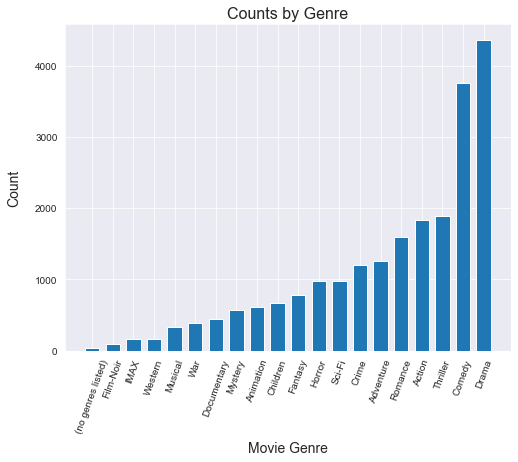

In [18]:
plt.figure(figsize=(8, 6))
plt.bar(list(sortedcount.keys()),list(sortedcount.values()), width=.7, )
plt.ylabel("Count", labelpad=14, fontsize=14)
plt.xlabel("Movie Genre", labelpad=7, fontsize=14)
plt.title("Counts by Genre", fontsize=16);
plt.xticks(rotation=70);

### Word Cloud ON TAGS 

In [19]:
def plot_wordcloud(data):
    removed = set(['Netflix queue','queue','Netflix']).union(STOPWORDS)
    filtered = data.loc[~data['tag'].isin(removed)]['tag']
    wc = WordCloud(stopwords = removed,background_color='white', include_numbers=True, min_word_length=4, width=600, height=900).generate(' '.join(filtered ))

    plt.figure(figsize = (6, 9), facecolor = None);
    plt.imshow(wc)
    plt.axis('off')
    plt.tight_layout(pad = 0) 

    plt.show;

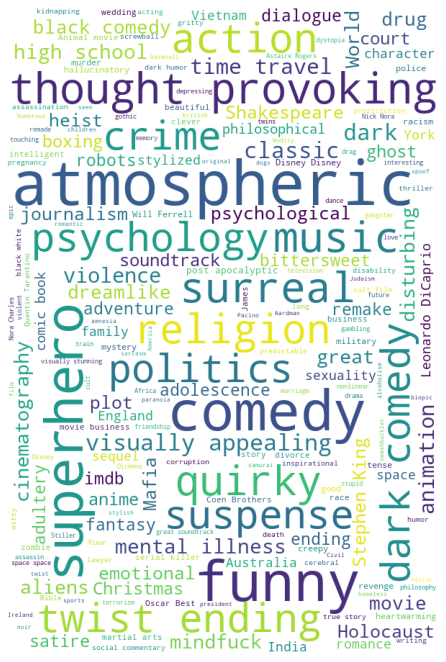

In [20]:
plot_wordcloud(tags_df)

#Lets do only from movies rated >= 4.5 and then another with movies <=1.5

In [21]:
result5 = ratings_df[ratings_df['rating'] <=1.5]
result5w_tag = pd.merge(result5, tags_df, left_index=True, right_index=True, how="inner")

In [22]:
result5w_tag

,userId_x,movieId_x,rating,userId_y,movieId_y,tag
205,1,3176,1.0,62,60756,comedy
261,3,31,0.5,62,99114,Soundtrack
262,3,527,0.5,62,99114,western
263,3,647,0.5,62,103042,Amy Adams
264,3,688,0.5,62,103042,superhero
...,...,...,...,...,...,...
3651,21,149380,1.5,599,2959,Palahnuik
3653,21,160565,1.0,599,2959,philosophy
3654,21,160872,0.5,599,2959,postmodern
3661,21,173307,0.5,599,2959,schizophrenia


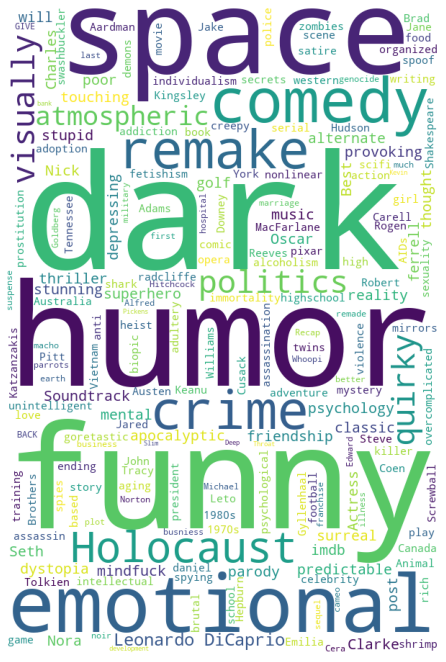

In [23]:
plot_wordcloud(result5w_tag)

#  Model

Surprise is a scikit package for building and analysing recommender systems maintained by Nicolas Hug.

In [24]:
from surprise import Reader, Dataset
reader = Reader()
ratings_sp = Dataset.load_from_df(ratings_df,reader)

In [25]:
from surprise.model_selection import cross_validate, GridSearchCV
from surprise.prediction_algorithms import SVD, NMF, SlopeOne, CoClustering 
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline, BaselineOnly
import numpy as np

### Cross Validate


The SVD procedure function transforms an m-by-n matrix a to the product of an m-by-n column orthogonal matrix u, an n-by-n diagonal matrix w, and the transpose of an n-by-n orthogonal matrix v. In other words, u, w, and v are matrices that are calculated by SVD.

In [154]:
cross_validate(SVD(), ratings_sp, measures=['RMSE', 'MAE'], cv=10, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.8775  0.8690  0.8711  0.8638  0.8623  0.8651  0.8697  0.8781  0.8719  0.8670  0.8696  0.0051  
MAE (testset)     0.6728  0.6653  0.6703  0.6634  0.6635  0.6649  0.6672  0.6763  0.6640  0.6625  0.6670  0.0044  
Fit time          4.73    4.74    4.86    5.49    5.16    5.22    4.90    4.92    4.89    4.96    4.99    0.22    
Test time         0.06    0.06    0.06    0.07    0.06    0.06    0.28    0.07    0.06    0.08    0.09    0.07    


{'test_rmse': array([0.87751589, 0.86900181, 0.87114076, 0.86382491, 0.86226675,
        0.86514718, 0.8697337 , 0.87807446, 0.87188484, 0.86697911]),
 'test_mae': array([0.67281814, 0.66534114, 0.6703441 , 0.66341578, 0.66345156,
        0.66485563, 0.66722929, 0.67629267, 0.66399701, 0.66245899]),
 'fit_time': (4.730003595352173,
  4.741967439651489,
  4.858133316040039,
  5.488963603973389,
  5.16413950920105,
  5.221394777297974,
  4.901141881942749,
  4.917079925537109,
  4.888082027435303,
  4.956222057342529),
 'test_time': (0.06403565406799316,
  0.06103229522705078,
  0.0610041618347168,
  0.06999874114990234,
  0.06399989128112793,
  0.06498527526855469,
  0.2849917411804199,
  0.07300710678100586,
  0.06400084495544434,
  0.0789649486541748)}

Non-negative matrix factorization, another matrix factorization method where a matrix V is factorized into (usually) two matrices W and H, W and H, with the property that all three matrices have no negative elements.

In [27]:
cross_validate(NMF(), ratings_sp, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9208  0.9230  0.9251  0.9302  0.9124  0.9223  0.0058  
MAE (testset)     0.7044  0.7072  0.7079  0.7121  0.6998  0.7063  0.0041  
Fit time          5.19    5.24    5.35    5.32    5.38    5.30    0.07    
Test time         0.16    0.13    0.15    0.11    0.10    0.13    0.02    


{'test_rmse': array([0.92081966, 0.9229778 , 0.92512711, 0.9302193 , 0.91242297]),
 'test_mae': array([0.70438919, 0.70720189, 0.70787526, 0.71209037, 0.69976358]),
 'fit_time': (5.192035436630249,
  5.239001035690308,
  5.353037595748901,
  5.3179991245269775,
  5.382961273193359),
 'test_time': (0.1580033302307129,
  0.12700104713439941,
  0.15399909019470215,
  0.11296463012695312,
  0.10303521156311035)}

SlopeOne algorithm arguably it is the simplest form of non-trivial item-based collaborative filtering based on ratings

In [28]:
cross_validate(SlopeOne(), ratings_sp, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SlopeOne on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8990  0.8948  0.9012  0.9022  0.9015  0.8997  0.0027  
MAE (testset)     0.6877  0.6829  0.6869  0.6892  0.6892  0.6872  0.0023  
Fit time          4.18    4.00    3.99    4.12    3.96    4.05    0.09    
Test time         6.27    6.58    6.46    6.36    6.61    6.46    0.13    


{'test_rmse': array([0.89900666, 0.89477656, 0.90123851, 0.90219907, 0.90150875]),
 'test_mae': array([0.68774964, 0.68291154, 0.68686472, 0.68920384, 0.68924964]),
 'fit_time': (4.18496298789978,
  3.998981237411499,
  3.994962453842163,
  4.122996807098389,
  3.9559998512268066),
 'test_time': (6.267036437988281,
  6.580971717834473,
  6.456053972244263,
  6.364983320236206,
  6.613984107971191)}

CoClustering goal is to generate biclusters/co-clusters: a subset of rows which exhibit similar behavior across a subset of columns

In [29]:
cross_validate(CoClustering(), ratings_sp, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm CoClustering on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9401  0.9382  0.9456  0.9414  0.9445  0.9420  0.0027  
MAE (testset)     0.7269  0.7305  0.7331  0.7274  0.7297  0.7295  0.0022  
Fit time          2.71    2.79    2.82    2.85    2.83    2.80    0.05    
Test time         0.10    0.14    0.09    0.10    0.15    0.12    0.02    


{'test_rmse': array([0.94005751, 0.93822905, 0.94564783, 0.94143115, 0.94446056]),
 'test_mae': array([0.7269174 , 0.73048561, 0.73308119, 0.72738538, 0.72973946]),
 'fit_time': (2.714000940322876,
  2.786001205444336,
  2.820998430252075,
  2.847975254058838,
  2.8259646892547607),
 'test_time': (0.10003304481506348,
  0.138016939163208,
  0.09003567695617676,
  0.09703922271728516,
  0.15003442764282227)}

In [ ]:
BaselineOnly 

In [30]:
cross_validate(BaselineOnly(), ratings_sp, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE, MAE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8777  0.8726  0.8705  0.8756  0.8661  0.8725  0.0040  
MAE (testset)     0.6783  0.6741  0.6713  0.6743  0.6653  0.6727  0.0043  
Fit time          0.25    0.26    0.26    0.24    0.26    0.25    0.01    
Test time         0.09    0.08    0.14    0.08    0.08    0.09    0.02    


{'test_rmse': array([0.87774023, 0.87255962, 0.87046804, 0.87558592, 0.86612012]),
 'test_mae': array([0.67833621, 0.67407273, 0.671319  , 0.67428522, 0.66532705]),
 'fit_time': (0.25200390815734863,
  0.26496458053588867,
  0.25501227378845215,
  0.24395012855529785,
  0.2569546699523926),
 'test_time': (0.0899968147277832,
  0.08105039596557617,
  0.13795161247253418,
  0.08399391174316406,
  0.08003473281860352)}

In [63]:
cross_validate(KNNWithMeans(), ratings_sp, measures=['RMSE', 'MAE'], cv=10, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.9005  0.8821  0.8874  0.8872  0.8823  0.8898  0.8941  0.9021  0.9080  0

{'test_rmse': array([0.90046435, 0.88206995, 0.88735816, 0.8872334 , 0.8822757 ,
        0.88976637, 0.89412401, 0.90210678, 0.90803516, 0.89029125]),
 'test_mae': array([0.68387012, 0.67737693, 0.6784591 , 0.6823854 , 0.67550969,
        0.67755682, 0.68179216, 0.68458461, 0.69047427, 0.68279961]),
 'fit_time': (0.2200021743774414,
  0.24094700813293457,
  0.24700021743774414,
  0.27596449851989746,
  0.2389824390411377,
  0.2469625473022461,
  0.2489912509918213,
  0.2400531768798828,
  0.24301695823669434,
  0.24198436737060547),
 'test_time': (0.9230015277862549,
  0.8270382881164551,
  0.8519845008850098,
  0.9020426273345947,
  0.814000129699707,
  0.8289997577667236,
  0.838965892791748,
  0.850017786026001,
  0.7829830646514893,
  0.8400039672851562)}

In [61]:
cross_validate(KNNBasic(), ratings_sp, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9515  0.9454  0.9486  0.9439  0.9397  0.9458  0.0040  
MAE (testset)     0.7274  0.7238  0.7297  0.7254  0.7207  0.7254  0.0031  
Fit time          0.16    0.19    0.21    0.18    0.17    0.18    0.02    
Test time         1.39    1.40    1.45    1.30    1.46    1.40    0.06    


{'test_rmse': array([0.9514752 , 0.94536846, 0.94855617, 0.94390515, 0.9397011 ]),
 'test_mae': array([0.72738802, 0.72383563, 0.72965008, 0.72538475, 0.72065804]),
 'fit_time': (0.15994691848754883,
  0.19300174713134766,
  0.20996737480163574,
  0.17695069313049316,
  0.1739664077758789),
 'test_time': (1.3870344161987305,
  1.4030020236968994,
  1.4450345039367676,
  1.3000402450561523,
  1.4610002040863037)}

In [62]:
cross_validate(KNNBaseline(), ratings_sp, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBaseline on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8798  0.8721  0.8709  0.8659  0.8852  0.8748  0.0069  
MAE (testset)     0.6740  0.6657  0.6652  0.6618  0.6763  0.6686  0.0056  
Fit time          0.41    0.42    0.44    0.42    0.41    0.42    0.01    
Test time         1.84    1.88    1.85    1.88    1.95    1.88    0.04    


{'test_rmse': array([0.87984393, 0.87210233, 0.87087456, 0.86587917, 0.88516392]),
 'test_mae': array([0.67398099, 0.66573038, 0.66524779, 0.66176168, 0.6763039 ]),
 'fit_time': (0.4089622497558594,
  0.41605186462402344,
  0.44196534156799316,
  0.418964147567749,
  0.41299962997436523),
 'test_time': (1.8420038223266602,
  1.880998134613037,
  1.8480350971221924,
  1.877035140991211,
  1.9479830265045166)}

### Gridsearch SVD

#### Gridsearch on SVD

In [31]:
%%script echo skipping 
params = {'n_factors': [10,25,50,75,100],
         'reg_all': [0.02, 0.04, 0.06, 0.08, 0.1]}
gs_svd = GridSearchCV(SVD,param_grid=params,n_jobs=-1)
gs_svd.fit(ratings_sp)

skipping


In [32]:
%%script echo skipping 
print(gs_svd.best_score)
print(gs_svd.best_params)

skipping


Based off these outputs, it seems like the best performing model is the SVD model with n_factors = 75 and a regularization rate of 0.06.

#### Gridsearch on BaselineOnly ALS

In [33]:
%%script echo skipping
params = {'bsl_options': {'method': ['als'],
                              'reg_i': [8, 9, 10, 11, 12], # lambda 2
                              'reg_u': [3, 4, 5, 6, 7],# lambda 3
                             }
         }
gs_bo = GridSearchCV(BaselineOnly,param_grid=params,n_jobs=-1)
gs_bo.fit(ratings_sp)

skipping


In [34]:
%%script echo skipping 
print(gs_bo.best_score)
print(gs_bo.best_params)

skipping


#### Gridsearch on KNNWithMeans

In [65]:
params = {'n_factors': [10,25,50,75,100],
         'reg_all': [0.02, 0.04, 0.06, 0.08, 0.1]}

gs_knn = GridSearchCV(KNNWithMeans,param_grid=params,n_jobs=-1)
gs_knn.fit(ratings_sp)

print(gs_knn.best_score)
print(gs_knn.best_params)

{'rmse': 0.8959297009455709, 'mae': 0.6845950316280579}
{'rmse': {'n_factors': 10, 'reg_all': 0.02}, 'mae': {'n_factors': 10, 'reg_all': 0.02}}


### Recommendations

#### Functions
For cold start ratedriver calls new_interview and movierater to ask about the top 3 genres
and askes user to rate the movies in thos specified genres.

In [35]:
def new_interview(userID):
    genIds = []
    genres = { '1' :'Action' , '2' :'Adventure' , '3' :'Drama', '4' :'Comedy' , '5' :'Horror' , '6' :'Sci-Fi'}
    top3 = []
    num = 1
    print(genres)
    while num > 0 :
        g1, g2, g3 = input('\033[1m' + 'Please enter your top 3 genres from below.  Example: 2 3 5 :\n' + '\033[0m').split()
        genIds.append(g1)
        genIds.append(g2)
        genIds.append(g3)
        num -= 1

    for gid in genIds:
        top3.append(genres.get(gid))
        
    return top3


In [36]:
def rate_driver(userID):
    genres = { 1 :'Action' , 2 :'Adventure' ,3 :'Drama', 4 :'Comedy' , 5:'Horror' , 6:'Sci-Fi'}
    topgenres = new_interview(userID)
    init_user_rates = []

    for genre in topgenres:
        #rate 3 movies for the genre
        init_user_rates.extend(movie_rater(userID, 3, genre))
        
    return init_user_rates
            

In [58]:
def movie_rater(movie_df, num, genre=None):
    userID = 1000
    rating_list = []
    print('\033[1m' + genre)
    print('\033[0m')

    while num > 0:
        
        print('##################################################################')
        if genre:
            movie = movies_df[movies_df['genres'].str.contains(genre)].sample(1)
        else:
            movie = movies_df.sample(1)
        print(movie)
        rating = input('Please rate on a scale of .5-5, press n if you have not seen :\n')
        if rating == 'n':
            continue
        else:
            rating_one_movie = {'userId':userID,'movieId':movie['movieId'].values[0],'rating':rating}
            rating_list.append(rating_one_movie) 
            print('\n')
            num -= 1
    return rating_list    

In [78]:
# return the top n recommendations using the 
def recommended_movies(user_ranks,movie_title_df,n,genre=None):
        
    for idx, rec in enumerate(user_ranks):
            #movies = movie_title_df[movie_title_df['genres'].str.contains(g)][:5]

            title = movie_title_df.loc[movie_title_df['movieId'] == int(rec[0])]['title']
            title = str(title).rpartition('\n')[0][4:]
            genre = movie_title_df.loc[movie_title_df['movieId'] == int(rec[0])]['genres']
            genre = str(genre).rpartition('\n')[0][4:]
            print('Rec# ', idx+1, ': ','\033[1m' + title + '\033[0m', genre,'\n')
            n-= 1
            if n == 0:
                break


#### Recommendation PreProcess

In [39]:
dataset = ratings_sp.build_full_trainset()
print('Number of users: ', dataset.n_users, '\n')
print('Number of items: ', dataset.n_items)

Number of users:  610 

Number of items:  9724


In [40]:
svd = SVD(n_factors= 25, reg_all=0.04)
svd.fit(dataset)

In [41]:
#predict for first user and first movie
#last user first movie
svd.predict(1, 1)


Prediction(uid=1, iid=1, r_ui=None, est=4.565199833435431, details={'was_impossible': False})

In [42]:
### last user first movie
svd.predict(610, 1)


Prediction(uid=610, iid=1, r_ui=None, est=4.06830179662995, details={'was_impossible': False})

#### INITIAL COLD START 

3 movie rate questions for 3 top genres
user_rating = rate_driver(1000)

In [146]:
user_rating = rate_driver(1000)

{'1': 'Action', '2': 'Adventure', '3': 'Drama', '4': 'Comedy', '5': 'Horror', '6': 'Sci-Fi'}
Please enter your top 3 genres from below.  Example: 2 3 5 :
2 3 4
Adventure

##################################################################
      movieId                        title                           genres
3901     5479  K-19: The Widowmaker (2002)  Action|Adventure|Drama|Thriller
Please rate on a scale of .5-5, press n if you have not seen :
1


##################################################################
      movieId                                  title  \
2539     3400  We're Back! A Dinosaur's Story (1993)   

                                    genres  
2539  Adventure|Animation|Children|Fantasy  
Please rate on a scale of .5-5, press n if you have not seen :
1


##################################################################
     movieId                    title                            genres
656      849  Escape from L.A. (1996)  Action|Adventure|Sci-Fi|Thri

In [147]:
##### append the new ratings to the original ratings DataFrame
delta_ratings_df = ratings_df.append(user_rating,ignore_index=True)
delta_rating_sp = Dataset.load_from_df(delta_ratings_df,reader)

In [148]:
#%%script echo skipping
# train a model using the new combined DataFrame
svd2 = SVD(n_factors= 25, reg_all=0.04)
svd2.fit(delta_rating_sp.build_full_trainset())

In [149]:
%%script echo skipping
# train a model using the new combined DataFrame
knn2 = KNNWithMeans(n_factors= 10, reg_all=0.2)
knn2.fit(delta_rating_sp.build_full_trainset())

skipping


In [150]:
#make predictions for the user
#in the format (movie_id, predicted_score)
list_of_movies = []
for m_id in delta_ratings_df['movieId'].unique():
    list_of_movies.append( (m_id, svd2.predict(1000, m_id)[3]))

In [151]:
# order the predictions from highest to lowest rated
ranked_movies = sorted(list_of_movies, key=lambda x:x[1], reverse=True)

#### Recommend Movies

In [152]:
#User id 1000
recommended_movies(ranked_movies,movies_df,5)

Rec#  1 :     Shawshank Redemption, The (1994)    Crime|Drama 

Rec#  2 :     Lawrence of Arabia (1962)    Adventure|Drama|War 

Rec#  3 :     Monty Python and the Holy Grail (1975)    Adventure|Comedy|Fantasy 

Rec#  4 :     Raiders of the Lost Ark (Indiana Jones and the...    Action|Adventure 

Rec#  5 :     Pulp Fiction (1994)    Comedy|Crime|Drama|Thriller 



In [153]:
delta_ratings_df.tail(20)

,userId,movieId,rating
100825,610,161634,4
100826,610,162350,3.5
100827,610,163937,3.5
100828,610,163981,3.5
100829,610,164179,5
100830,610,166528,4
100831,610,166534,4
100832,610,168248,5
100833,610,168250,5
100834,610,168252,5


# Interpret